In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot

# Importing the Data

In [2]:
df=pd.read_excel('Airlines+Data.xlsx')

In [3]:
df.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
df.tail()

,Month,Passengers
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


In [5]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


### Performing EDA

In [6]:
df[df.duplicated()].shape

(0, 2)

In [7]:
df[df.duplicated()] # No Duplicate values found

,Month,Passengers


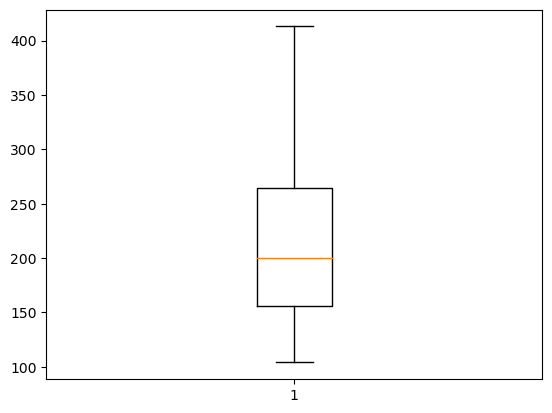

In [8]:
data_box=df.dropna()                     #No Outlier Detected hence no clening required
data_box1=data_box.Passengers
plt.boxplot(data_box1)
plt.show()

In [10]:
df.info() #No Null Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


# Plotting a Simple line plot for Sales Data

<AxesSubplot:>

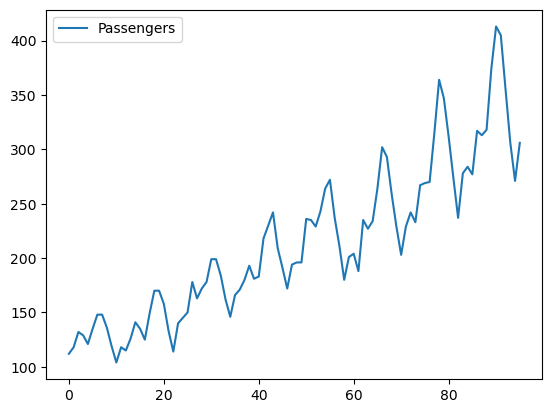

In [11]:
df['Passengers'].plot(legend=True)

In [12]:
# there is a trend 
# there is seasonality 

# #1. Square Root Transformation

In [13]:
df['Passengers']=sqrt(df['Passengers'])

In [14]:
df.head()

,Month,Passengers
0,1995-01-01,10.583005
1,1995-02-01,10.862780
2,1995-03-01,11.489125
3,1995-04-01,11.357817
4,1995-05-01,11.000000


<AxesSubplot:>

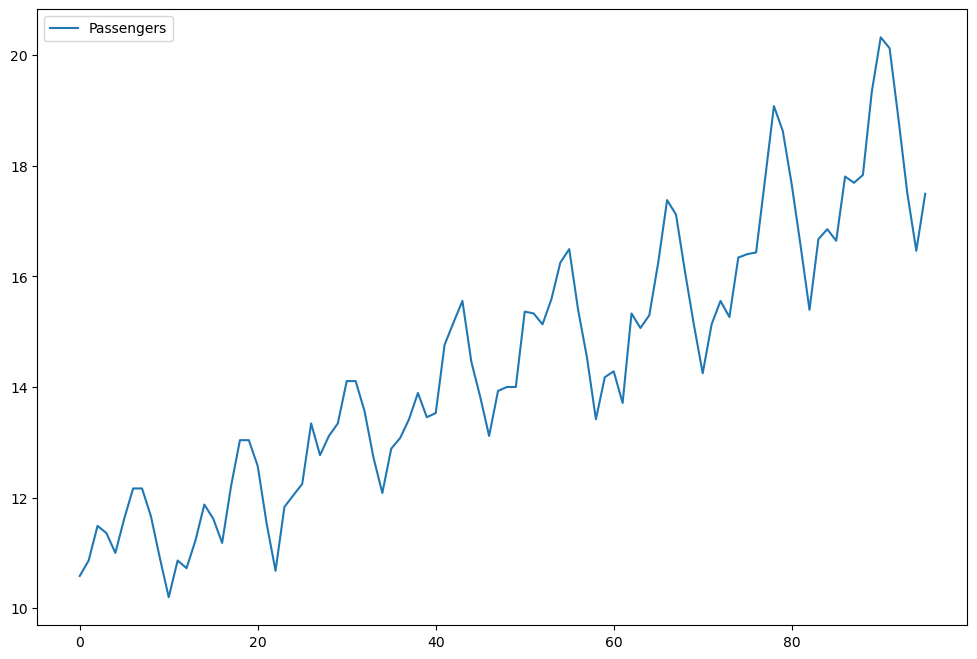

In [15]:
plt.figure(figsize=(12,8))
df['Passengers'].plot(legend=True)

# Check for Seasonality in Data

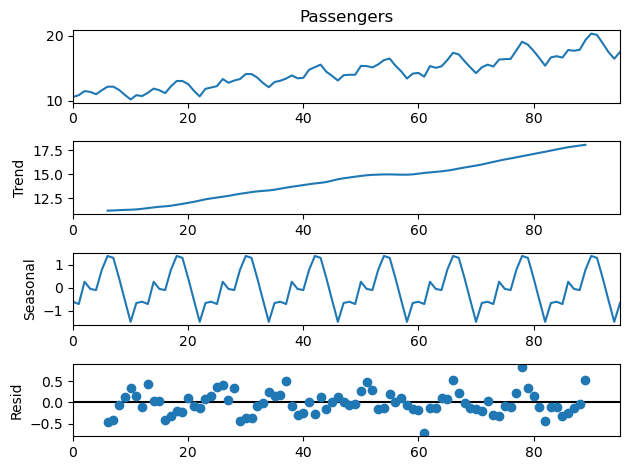

In [16]:
figsize = plt.figaspect(0.618) 
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
decompose_ts_add.plot()
plt.show()

In [17]:
#From the above plots it is seen that there is Trend and Seasonality in the data

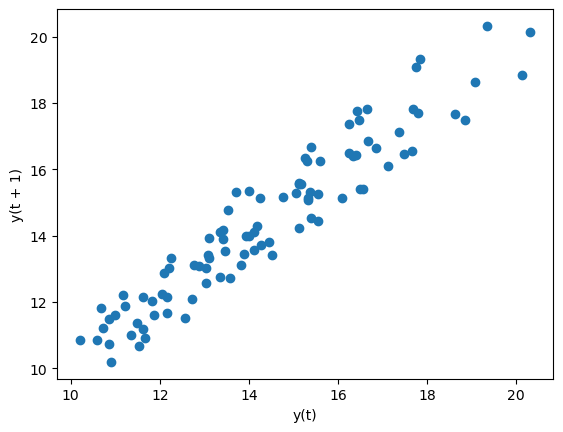

In [18]:
# Lag Plot

lag_plot(df['Passengers'])
plt.show()

# ACF and PACF Plots

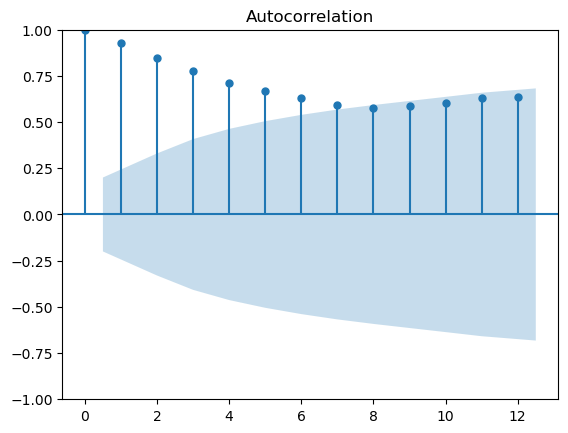

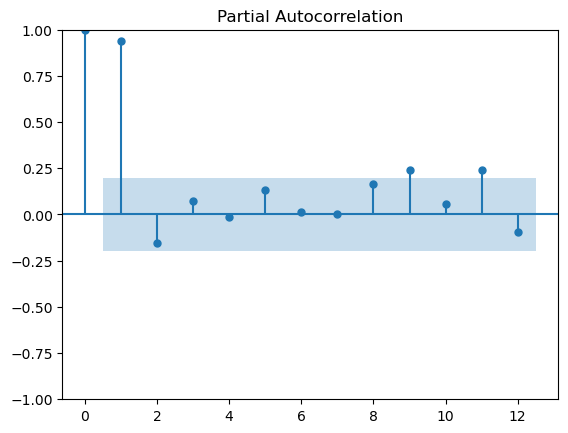

In [19]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(df.Passengers,lags=12)
tsa_plots.plot_pacf(df.Passengers,lags=12)
plt.show()

# Performing Simple Exponential Smoothing

In [20]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
alpha=0.15

In [21]:
model_ses= SimpleExpSmoothing(df['Passengers'])
fitted_model=model_ses.fit(smoothing_level=alpha,optimized=False)
fitted_model.fittedvalues

0     10.583005
1     10.583005
2     10.624972
3     10.754595
4     10.845078
        ...    
91    17.876433
92    18.213660
93    18.307827
94    18.185582
95    17.927056
Length: 96, dtype: float64

In [22]:
df['SES']=fitted_model.fittedvalues.shift(-1)
df.head()

,Month,Passengers,SES
0,1995-01-01,10.583005,10.583005
1,1995-02-01,10.862780,10.624972
2,1995-03-01,11.489125,10.754595
3,1995-04-01,11.357817,10.845078
4,1995-05-01,11.000000,10.868316


# Performing Double Exponential Smoothing

In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
mod_add12= ExponentialSmoothing(df['Passengers'],trend='add')
fitted_model=mod_add12.fit()

In [24]:
df['DES']=fitted_model.fittedvalues.shift(-1)
df.head()

,Month,Passengers,SES,DES
0,1995-01-01,10.583005,10.583005,10.655737
1,1995-02-01,10.862780,10.624972,10.935512
2,1995-03-01,11.489125,10.754595,11.561857
3,1995-04-01,11.357817,10.845078,11.430549
4,1995-05-01,11.000000,10.868316,11.072732


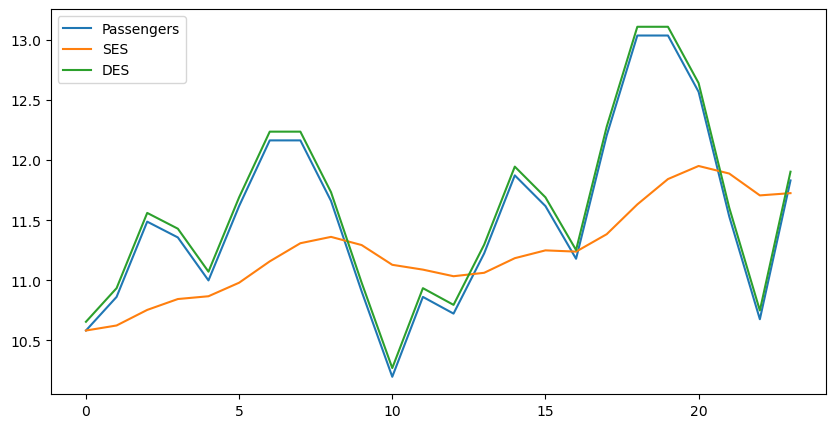

In [26]:
df[['Passengers',"SES",'DES']].iloc[:24].plot(figsize=(10,5));

From the above plot it is seen that SES  cannot handle data with trend and seasonality hence performing Holt Winter Method or DES

# Performing Holt Winters Method

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing        # triple Exponential Smoothing (holt winter method)

# Split the data by Train Test Split

In [28]:
train_data = df.iloc[:76]
test_data = df.iloc[76:]

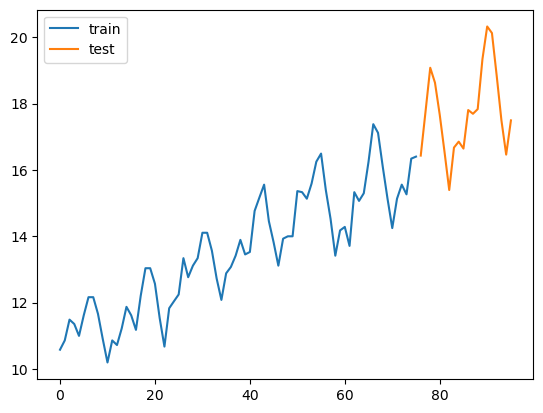

In [29]:
train_data['Passengers'].plot(legend=True, label='train'),
test_data['Passengers'].plot(legend=True, label='test');


# Model Building

In [30]:
#Using Exponential Smoothening as SES and DES cannot handle Trend and Seasonality

In [31]:
model = ExponentialSmoothing(train_data["Passengers"], trend="add", seasonal="mul", seasonal_periods=12) #add the trend to the model
model_fit = model.fit()

### Forecasting using Test Data

In [32]:
test_pred  = model_fit.forecast(20)

In [33]:
test_pred

76    16.205954
77    17.099119
78    17.969509
79    18.030233
80    17.028063
81    15.990610
82    14.982086
83    15.984785
84    16.152041
85    16.174815
86    17.407364
87    17.118294
88    17.022259
89    17.956813
90    18.867109
91    18.927134
92    17.871614
93    16.779511
94    15.718205
95    16.766967
dtype: float64

In [34]:
test_prediction = pd.DataFrame()
test_prediction['month'] = test_data.Month
test_prediction['Passengers'] = test_data.Passengers
test_prediction['test_pred_passengers'] = test_pred
test_prediction

,month,Passengers,test_pred_passengers
76,2001-05-01,16.431677,16.205954
77,2001-06-01,17.748239,17.099119
78,2001-07-01,19.078784,17.969509
79,2001-08-01,18.627936,18.030233
80,2001-09-01,17.663522,17.028063
81,2001-10-01,16.552945,15.990610
82,2001-11-01,15.394804,14.982086
83,2001-12-01,16.673332,15.984785
84,2002-01-01,16.852300,16.152041
85,2002-02-01,16.643317,16.174815


[]

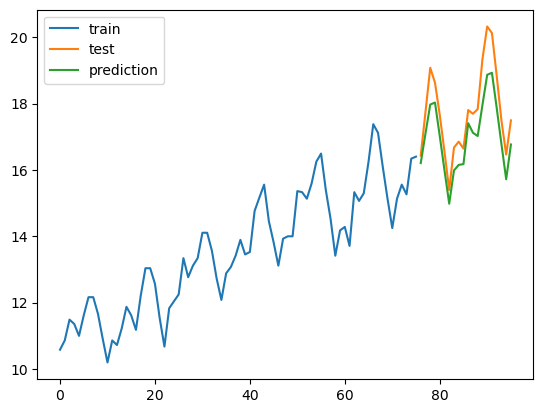

In [35]:
figsize = plt.figaspect(0.618) 
train_data['Passengers'].plot(legend=True, label='train')
test_data['Passengers'].plot(legend=True, label='test')
test_prediction['test_pred_passengers'].plot(legend=True, label='prediction')
plt.plot()

#### Transforming sqrt to original form of data for test prediction DataFrame 

In [36]:
test_prediction['Passengers'] = np.square(test_prediction['Passengers'])
test_prediction['test_pred_passengers'] = np.square(test_prediction['test_pred_passengers'])
test_prediction.head()

,month,Passengers,test_pred_passengers
76,2001-05-01,270.0,262.632961
77,2001-06-01,315.0,292.379868
78,2001-07-01,364.0,322.903237
79,2001-08-01,347.0,325.089309
80,2001-09-01,312.0,289.954925


#### Evaluation of metrics

In [37]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_prediction['Passengers'],test_prediction['test_pred_passengers'])         #MSE

876.756265422439

In [38]:
np.sqrt(mean_squared_error(test_prediction['Passengers'],test_prediction['test_pred_passengers'])) #RMSE

29.610070338019106

# Final model (forecasting into future)

In [39]:
model = ExponentialSmoothing(df["Passengers"], trend="add", seasonal="mul", seasonal_periods=12) #add the trend to the model
model_fit = model.fit()

In [40]:
fore  = model_fit.forecast(20)
fore

96     17.699156
97     17.666945
98     18.980810
99     18.691713
100    18.666138
101    19.862438
102    20.940812
103    20.846164
104    19.654759
105    18.398246
106    17.219730
107    18.392432
108    18.577783
109    18.540360
110    19.915330
111    19.608239
112    19.577684
113    20.828473
114    21.955184
115    21.851891
dtype: float64

<AxesSubplot:>

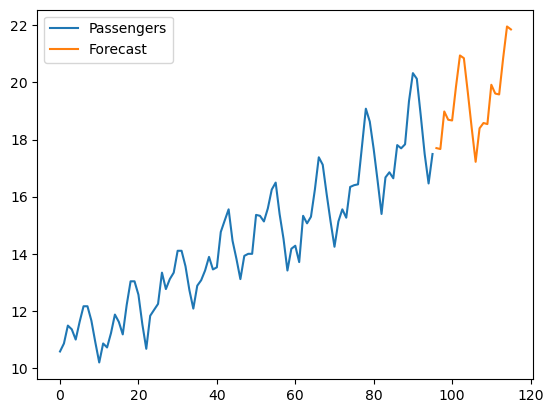

In [41]:
df['Passengers'].plot(legend=True)
fore.plot(legend=True, label='Forecast')

In [42]:
df['Passengers'] = np.square(df['Passengers']) 
fore = np.square(fore)

In [43]:
df.head()

,Month,Passengers,SES,DES
0,1995-01-01,112.0,10.583005,10.655737
1,1995-02-01,118.0,10.624972,10.935512
2,1995-03-01,132.0,10.754595,11.561857
3,1995-04-01,129.0,10.845078,11.430549
4,1995-05-01,121.0,10.868316,11.072732


In [44]:
fore

96     313.260121
97     312.120937
98     360.271167
99     349.380148
100    348.424690
101    394.516425
102    438.517605
103    434.562533
104    386.309543
105    338.495464
106    296.519115
107    338.281550
108    345.134018
109    343.744931
110    396.620361
111    384.483019
112    383.285708
113    433.825289
114    482.030119
115    477.505154
dtype: float64

<AxesSubplot:>

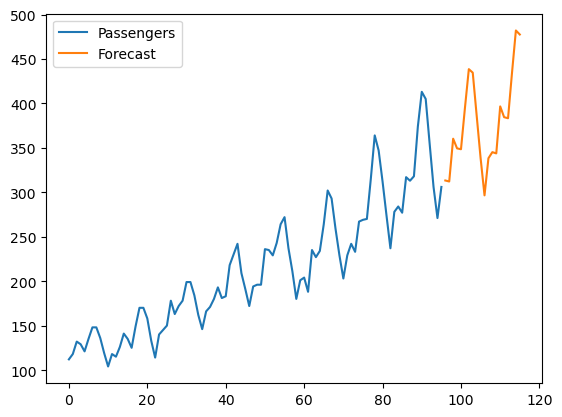

In [45]:
df['Passengers'].plot(legend=True)
fore.plot(legend=True, label='Forecast')